# Clustering

In [62]:
# Import KMeans from sklearn.cluster
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_theme()

# import data frames
%store -r final_data
# simplified dataframe with Principal components
%store -r data6D

# Determining ideal number of clusters
We will be trying two methods to determine the ideal number of clusters:  
1. Elbow method based on WSS  
2. Silhouette method  


### Elbow method
Varry clusters from 1 to 50

<AxesSubplot:xlabel='clusters', ylabel='wss'>

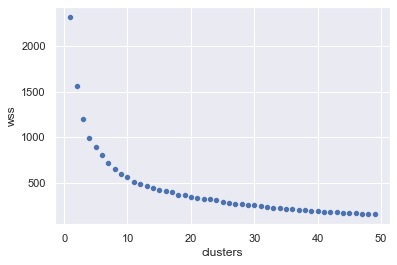

In [63]:
CLUSTERS = range(1,50) # clusters
CENTROID_SEL = "k-means++"

# exlcude countries
data6DCP = data6D.copy()
countries = data6DCP["Country"]
data6DCP = data6DCP.drop(columns=["Country"])

# array to store: (cluster_num, score)
scores = []

# generate WSS score for each cluster_num from 1 to 50
for num in CLUSTERS:
    kmeans = KMeans(n_clusters=num, init=CENTROID_SEL)
    model = kmeans.fit(data6DCP)
    wss = model.inertia_
    scores.append([num, wss])

# convert array to dataframe
scores = pd.DataFrame(scores, columns=["clusters", "wss"])

# plot the scores on "eblow plot"
sb.scatterplot(x="clusters", y="wss", data=scores)

From elbow method plot, the ideal number of clusters appears to be between 4 to 6

### Silouhette method

Silhouette score can be within a range of -1 to +1. The higher the score the better.  

score measures both cohesion (inter cluster closeness) and seperation (between cluster seperation).   

Each data point (x) has a value for cohesion and seperation. 
cohesion, a = mean of euclidean distance from x to every other point within the cluster  
seperation = mean of euclidean distance from x to every point in another cluster  
b = minimum of all the seperation scores (this gives us the average distance to the nearest cluster)  
silouhette coefficient = (b - a) / max(a,b)  
Since we want b to be as large as possible and a to be as small as possible: the best score is 1 and worst is -1  

Cluster with highest score:
   clusters     score
2         4  0.338396


<AxesSubplot:xlabel='clusters', ylabel='score'>

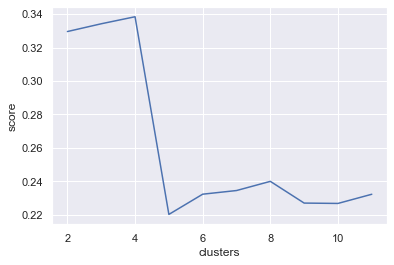

In [64]:
scores = []
CLUSTERS = CLUSTERS = range(2,12) # minimum of 2 clusters in needed to calculate silouhette score
for num in CLUSTERS:
    # labels is an array, where each  data-point is assigned to a cluster
    # example: [0,1,1,2,4,3,...] means that the first point is in cluster 0, 2nd point is in cluster 1 and so on
    labels = KMeans(n_clusters=num, init=CENTROID_SEL, random_state=200).fit(data6DCP).labels_

    # determine silouhette score
    score = metrics.silhouette_score(data6DCP, labels, metric="euclidean")
    scores.append([num, score])

# convert array to dataframe
scores = pd.DataFrame(scores, columns=["clusters", "score"])

# select maximum score
max = scores["score"].max()
print("Cluster with highest score:")
print(scores[scores["score"] == max])

# plot the scores on "eblow plot"
sb.lineplot(x="clusters", y="score", data=scores)


We will use 4 as our number of clusters according to the result from the silhouette score analysis 

# Creating and Evaluating KMeans model

In [65]:
OPTIMAL_CLUSTERS = 4
model = KMeans(n_clusters = OPTIMAL_CLUSTERS, init = CENTROID_SEL, n_init = 100).fit(data6DCP)


Within Cluster Sum of Squares : 988.923841343552



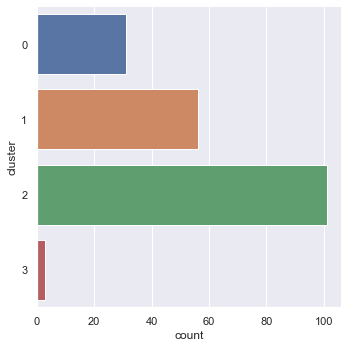

In [66]:
# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", model.inertia_)
print()

# Predict the Cluster Labels
cluster_labels = model.predict(data6DCP)

# add cluster labels back to data
clustered_data = data6DCP.copy()
clustered_data["cluster"] = pd.Categorical(cluster_labels)

# Summary of the Clusters
sb.catplot(y = "cluster", data = clustered_data, kind = "count")

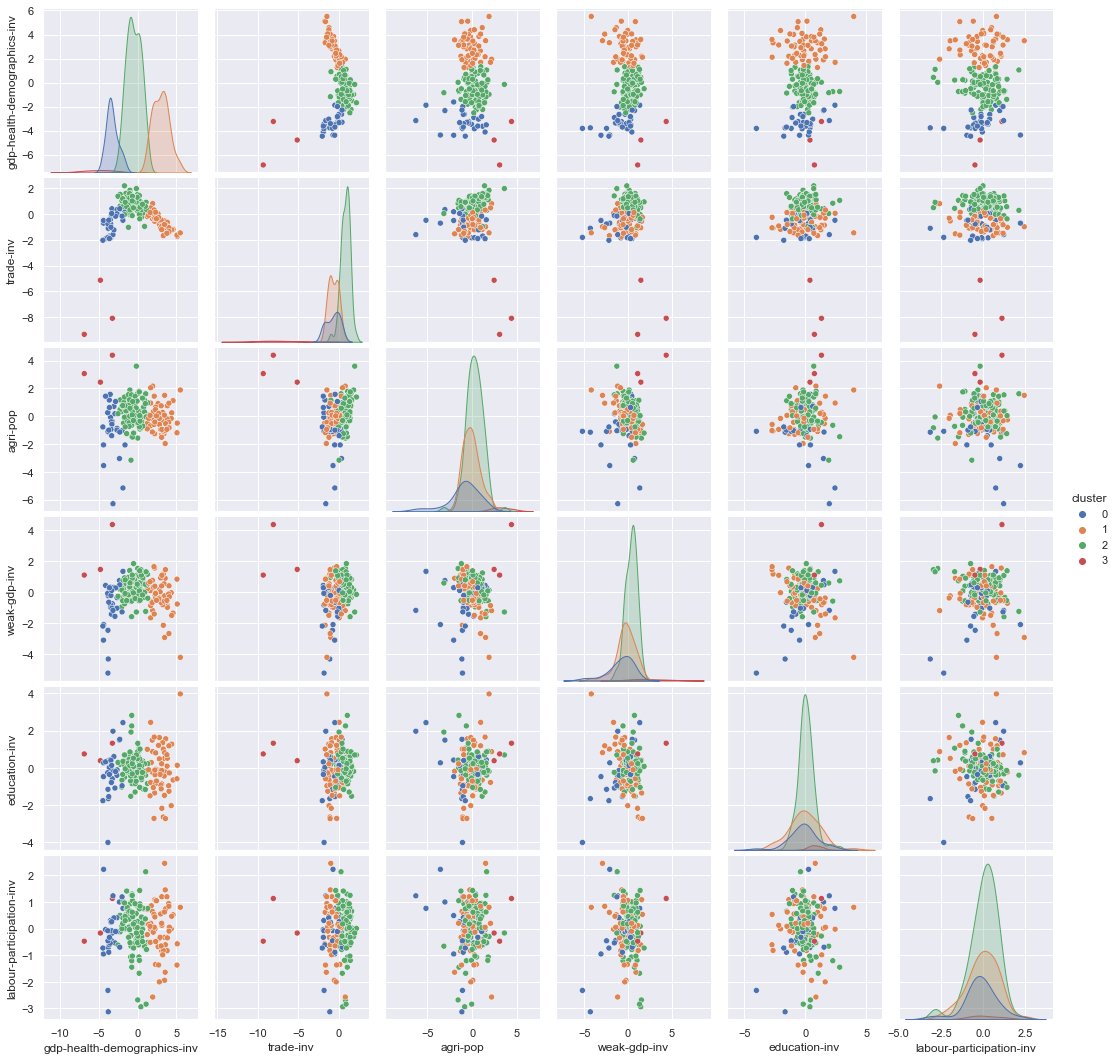

In [67]:
# Plot the Clusters on 2D grids
sb.pairplot(clustered_data, vars = data6DCP.columns.values, hue = "cluster")

In [68]:
# countries in cluster 0
clustered_data["Country"] = countries
cluster0 = clustered_data[clustered_data["cluster"] == 0]["Country"]
cluster1 = clustered_data[clustered_data["cluster"] == 1]["Country"]
cluster2 = clustered_data[clustered_data["cluster"] == 2]["Country"]
cluster3 = clustered_data[clustered_data["cluster"] == 3]["Country"]


In [69]:
clustered_data.head()

,gdp-health-demographics-inv,trade-inv,agri-pop,weak-gdp-inv,education-inv,labour-participation-inv,cluster,Country
0,3.473448,-0.537316,0.074081,-0.235088,0.511475,-1.941004,1,Afghanistan
1,-0.202452,1.186812,0.610414,1.070507,-0.234381,-0.595684,2,Albania
2,0.204608,0.443911,-0.728013,1.330052,1.061151,-1.678352,2,Algeria
3,-2.043319,0.576546,0.344473,-0.951513,-1.026634,0.069516,2,Andorra
4,3.554933,-1.534343,-1.964757,0.905562,-0.178777,-1.640465,1,Angola


In [70]:
print("Cluster 0")
print(cluster0)

Cluster 0
8                 Australia
9                   Austria
12                  Bahrain
16                  Belgium
24        Brunei Darussalam
31                   Canada
46                  Denmark
58                  Finland
59                   France
73                  Iceland
78                  Ireland
79                   Israel
80                    Italy
82                    Japan
87                   Kuwait
95            Liechtenstein
97               Luxembourg
109                  Monaco
118             Netherlands
119             New Zealand
123                  Norway
134                   Qatar
135       Republic of Korea
144              San Marino
146            Saudi Arabia
151               Singapore
158                   Spain
163                  Sweden
164             Switzerland
179    United Arab Emirates
180          United Kingdom
Name: Country, dtype: object


In [71]:
print("Cluster 1")
print(cluster1)

Cluster 1
0                           Afghanistan
4                                Angola
18                                Benin
20     Bolivia (Plurinational State of)
26                         Burkina Faso
27                              Burundi
29                             Cambodia
30                             Cameroon
32             Central African Republic
33                                 Chad
37                              Comoros
38                                Congo
45     Democratic Republic of the Congo
47                             Djibouti
53                    Equatorial Guinea
54                              Eritrea
56                             Ethiopia
61                               Gambia
64                                Ghana
68                               Guinea
70                                Haiti
85                                Kenya
86                             Kiribati
89     Lao People's Democratic Republic
92                            

In [72]:
print("Cluster 2")
print(cluster2)

Cluster 2
1                                 Albania
2                                 Algeria
3                                 Andorra
5                     Antigua and Barbuda
6                               Argentina
                      ...                
176                                Tuvalu
178                               Ukraine
183                               Uruguay
186    Venezuela (Bolivarian Republic of)
187                              Viet Nam
Name: Country, Length: 101, dtype: object


In [73]:
print("Cluster 3")
print(cluster3)

Cluster 3
35                        China
63                      Germany
182    United States of America
Name: Country, dtype: object


<AxesSubplot:xlabel='labour-participation-inv', ylabel='cluster'>

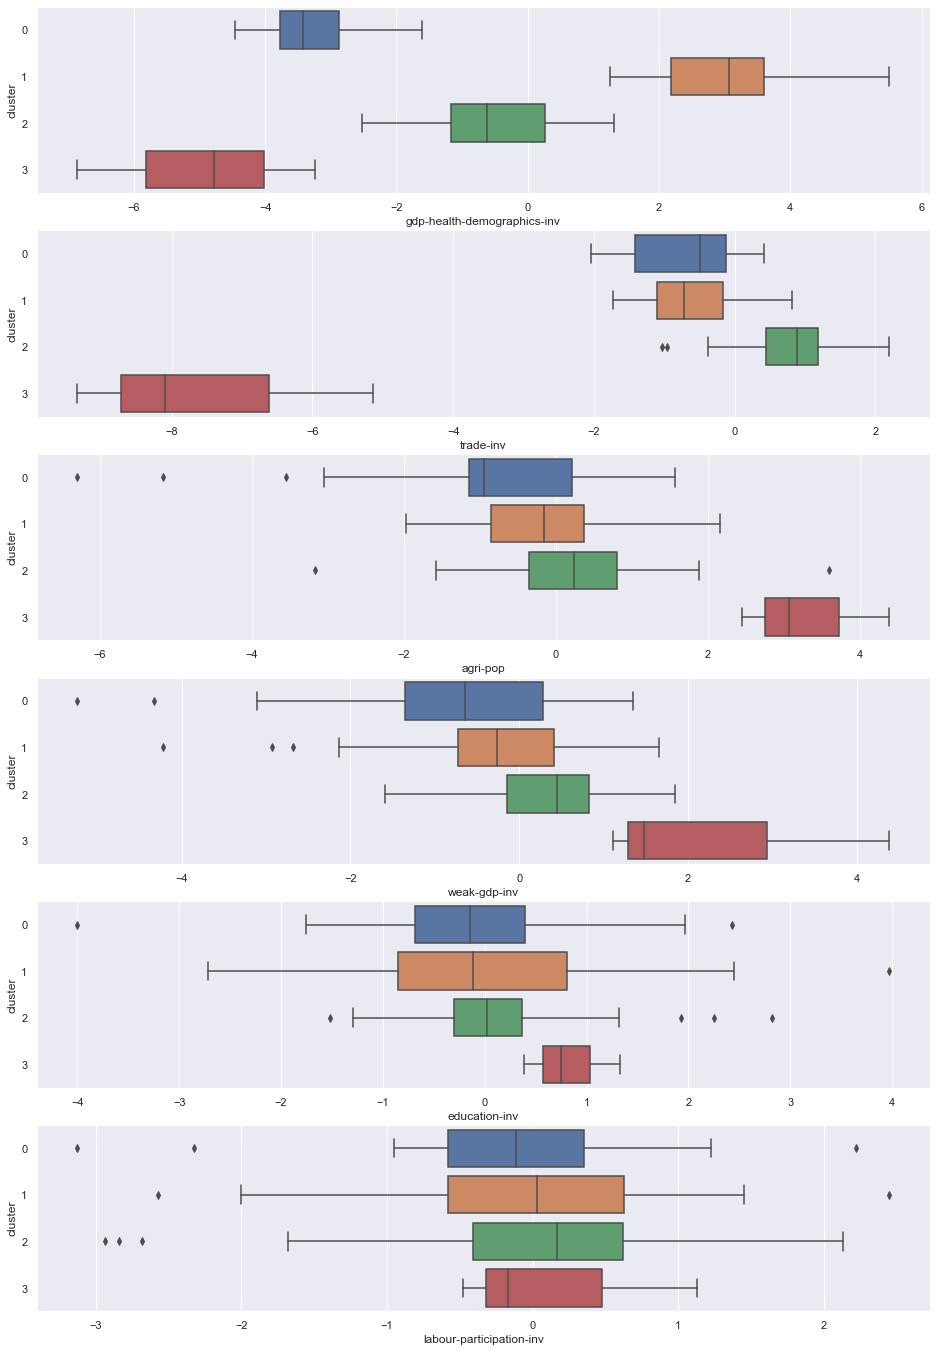

In [74]:
# Boxplots for all Features against the Clusters
f, axes = plt.subplots(6, 1, figsize=(16,24))
sb.boxplot(x = 'gdp-health-demographics-inv', y = 'cluster', data = clustered_data, ax = axes[0])
sb.boxplot(x = 'trade-inv', y = 'cluster', data = clustered_data, ax = axes[1])
sb.boxplot(x = 'agri-pop', y = 'cluster', data = clustered_data, ax = axes[2])
sb.boxplot(x = 'weak-gdp-inv', y = 'cluster', data = clustered_data, ax = axes[3])
sb.boxplot(x = 'education-inv', y = 'cluster', data = clustered_data, ax = axes[4])
sb.boxplot(x = 'labour-participation-inv', y = 'cluster', data = clustered_data, ax = axes[5])

<AxesSubplot:xlabel='cluster'>

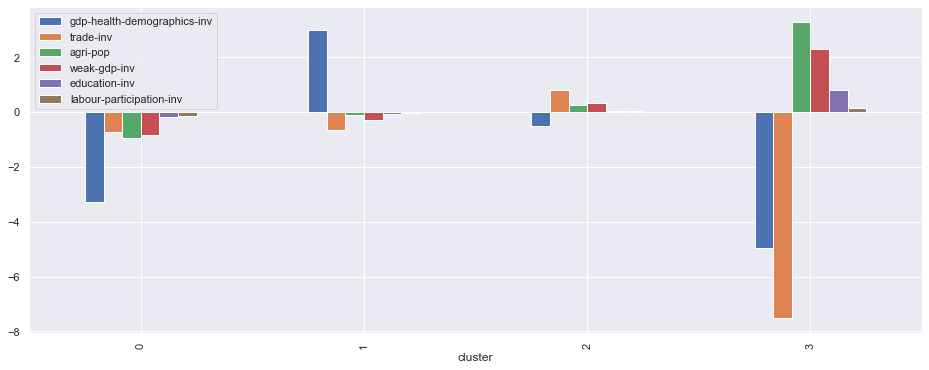

In [75]:
# Average Behaviour of each Cluster
grouped_data = pd.DataFrame(clustered_data.groupby(by = "cluster").mean())
grouped_data.plot.bar(figsize = (16,6))

### Insights
1. gdp-health-demographics-inv explains most of the variance between the countries  
2. Cluster 1 which contains the 3 "outliers" is likely due to the significantly negative trade balances the countries have.  
3. Cluster 3 which contains developed countries scored visibly lower on all indicators except for trade, where its distribution appears   similar to cluster 2.  
4. labour-participation-inv does not appear to be very useful in distinguishing clusters  
4. Cluster 2 scored highest for gdp-health-demographics-inv  

#### Summary
The least developed countries appear to be in cluster 0 and 1. We will explore these countries further.

In [76]:
#adding cluster to final_data
final_data = final_data.reset_index(drop=True)
final_data['cluster'] = clustered_data['cluster']
final_data

,GDP per capita (current US$),Economy: Agriculture (% of GVA),Agricultural production index (2004-2006=100),International trade: Exports (million US$),International trade: Imports (million US$),Population growth rate (average annual %),Urban population (% of total population),Infant mortality rate (per 1000 live births,Mobile-cellular subscriptions (per 100 inhabitants),Energy supply per capita (Gigajoules),country,Region,Average labour force participation,Average life expectancy,Average pop. using improved drinking water,Average Education: Primary gross enrol,Health expenditure per capita,cluster
0,623.2,23.3,125,1458.0,3568.0,3.2,26.7,68.6,61.6,5,Afghanistan,SouthernAsia,51.450,62.250,62.60,111.35,51.1024,1
1,3984.2,22.4,134,1962.0,4669.0,-0.1,57.4,14.6,106.4,36,Albania,SouthernEurope,50.600,77.750,95.05,113.60,235.0678,2
2,4154.1,12.2,160,29992.0,47091.0,2.0,70.7,27.7,113.0,55,Algeria,NorthernAfrica,43.850,75.300,83.05,116.10,299.0952,2
3,39896.4,0.5,115,100.0,1355.0,-1.6,85.1,18.0,88.1,119,Andorra,SouthernEurope,63.625,72.725,100.00,102.80,3231.6084,2
4,4714.1,6.8,175,21011.0,8790.0,3.5,44.1,65.4,60.8,25,Angola,MiddleAfrica,68.450,60.200,51.80,128.65,155.5653,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,11068.9,5.3,118,19731.0,16324.0,1.4,89.0,13.8,93.0,90,Venezuela (Bolivarian Republic of),SouthAmerica,64.900,74.050,86.45,99.95,586.6517,2
187,2067.9,18.9,136,176632.0,174111.0,1.1,33.6,19.3,130.6,30,Viet Nam,South-easternAsia,78.600,75.500,98.00,108.85,146.8209,2
188,1106.4,14.7,136,570.0,6861.0,2.6,34.6,47.2,68.0,12,Yemen,WesternAsia,49.950,64.200,59.25,97.30,61.9584,1
189,1311.1,8.2,179,6505.0,7442.0,3.0,40.9,53.8,74.5,26,Zambia,EasternAfrica,75.400,59.700,68.45,103.65,65.555,1


In [77]:
#dropping countries from clusters 2 and 3
#final_data_cut = final_data.drop(final_data[final_data.cluster == 2].index)
#final_data_cut.drop(final_data[final_data.cluster == 3].index,inplace=True)
#final_data_cut

In [78]:
final_data['cluster'].value_counts()

2    101
1     56
0     31
3      3
Name: cluster, dtype: int64

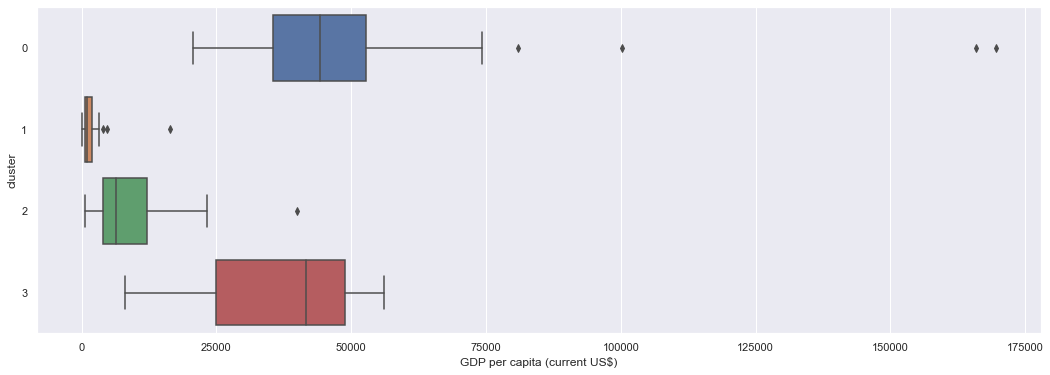

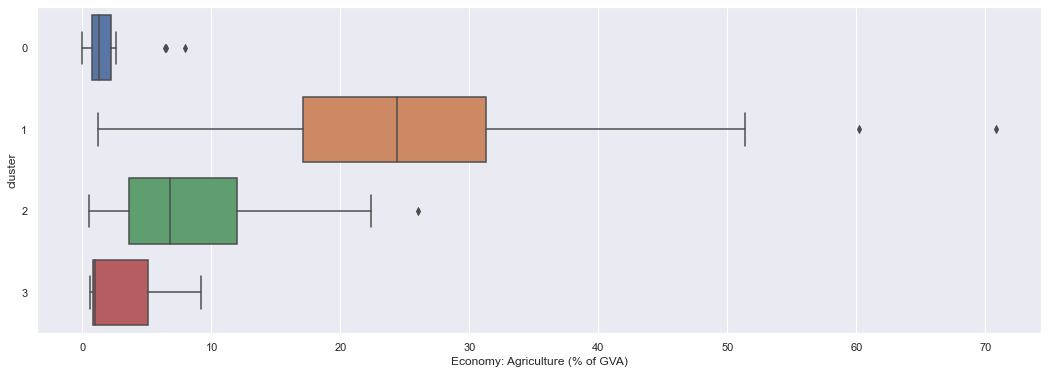

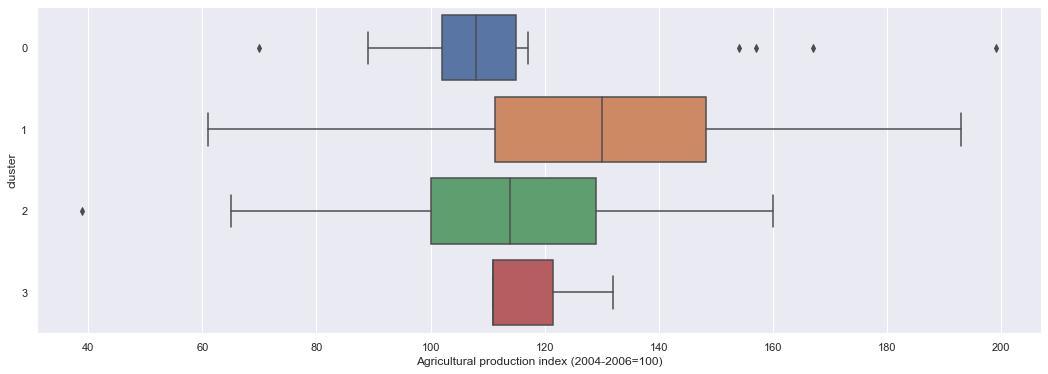

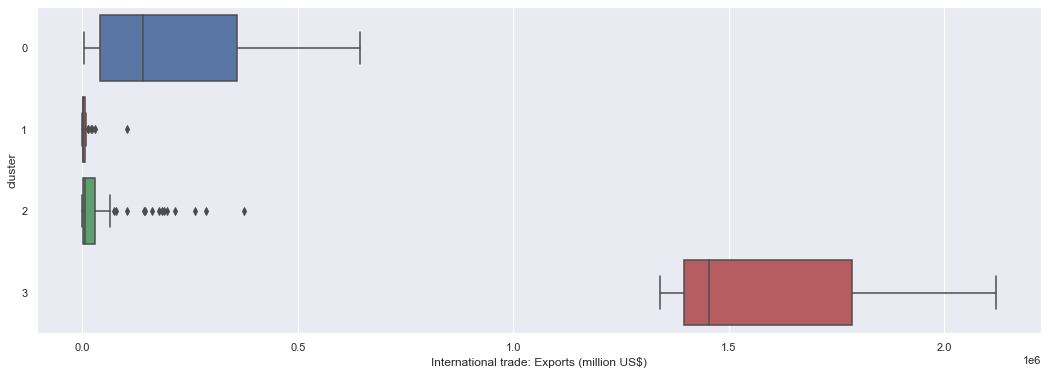

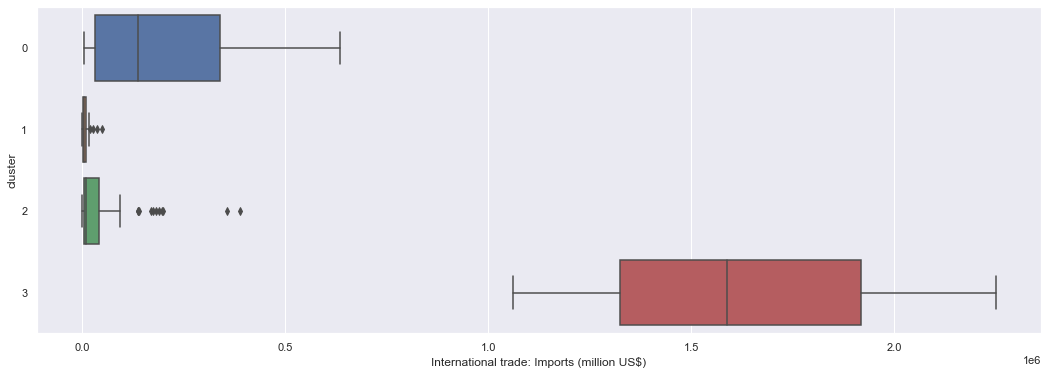

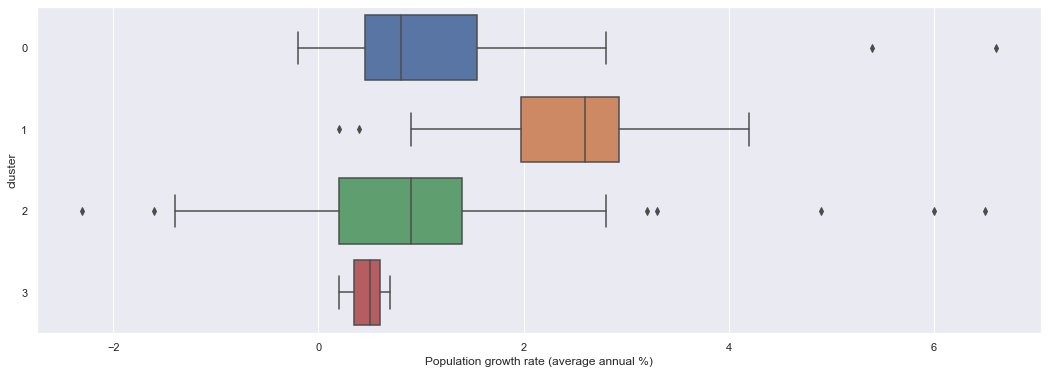

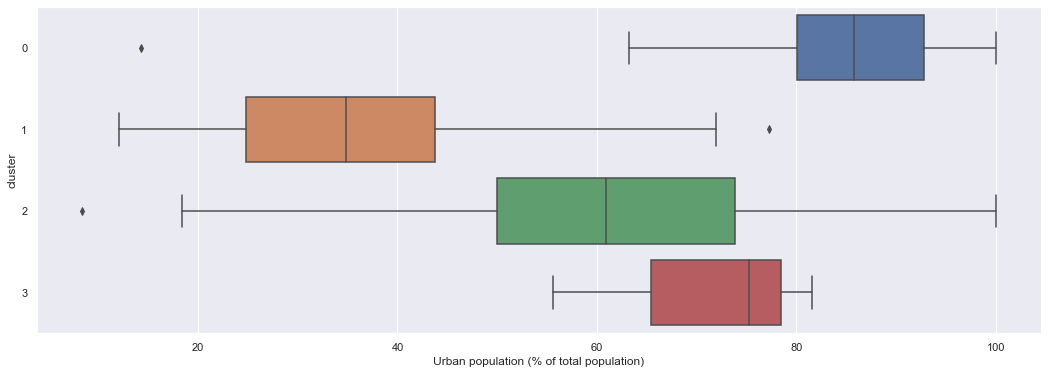

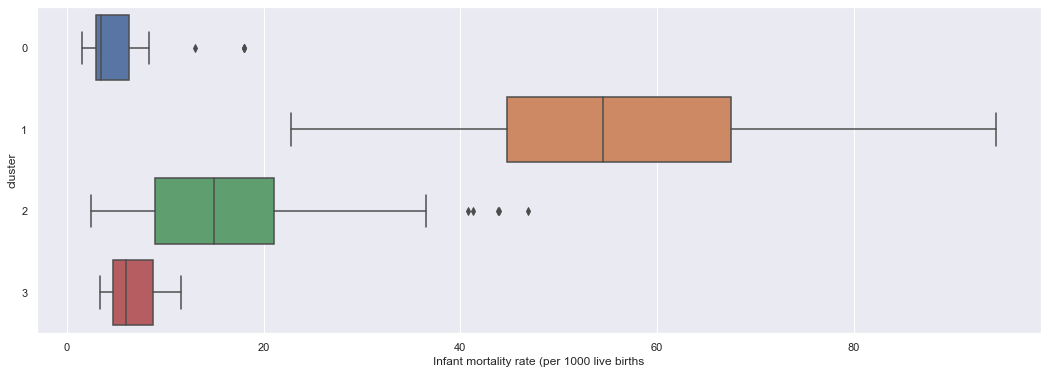

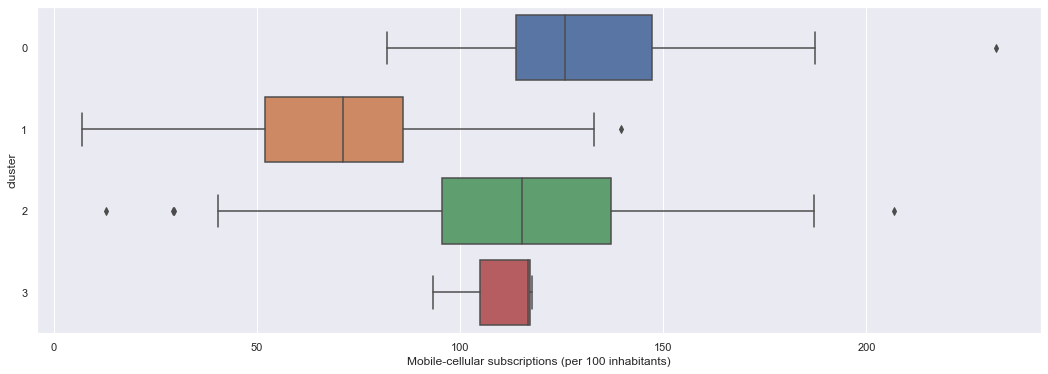

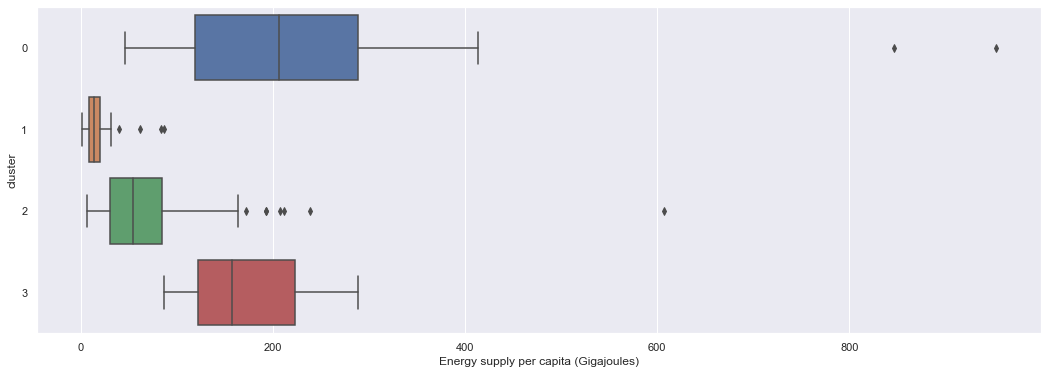

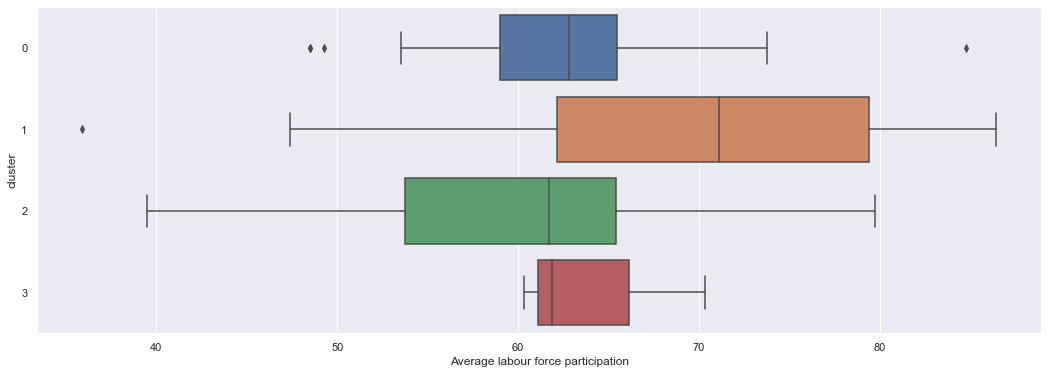

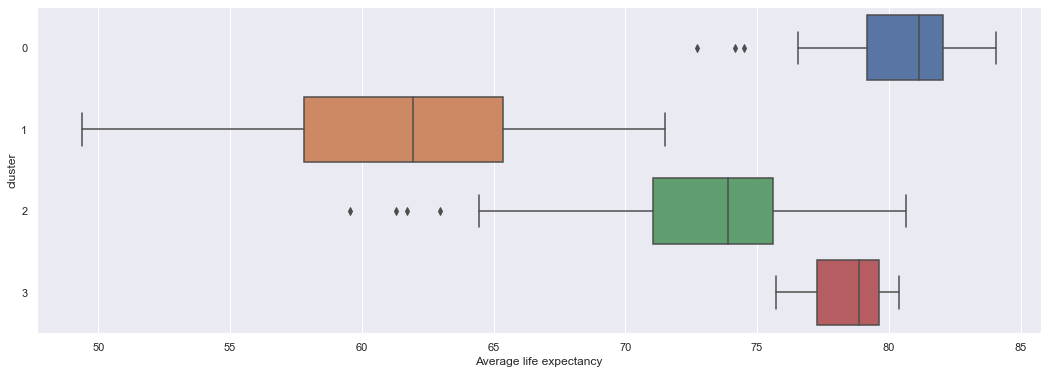

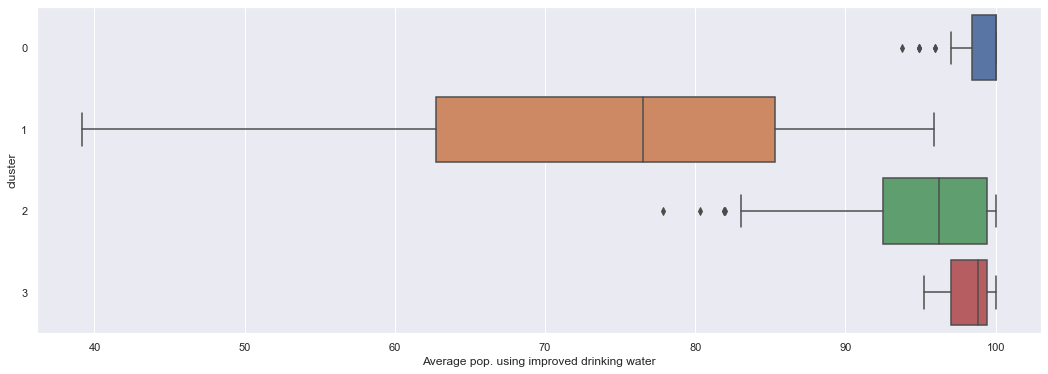

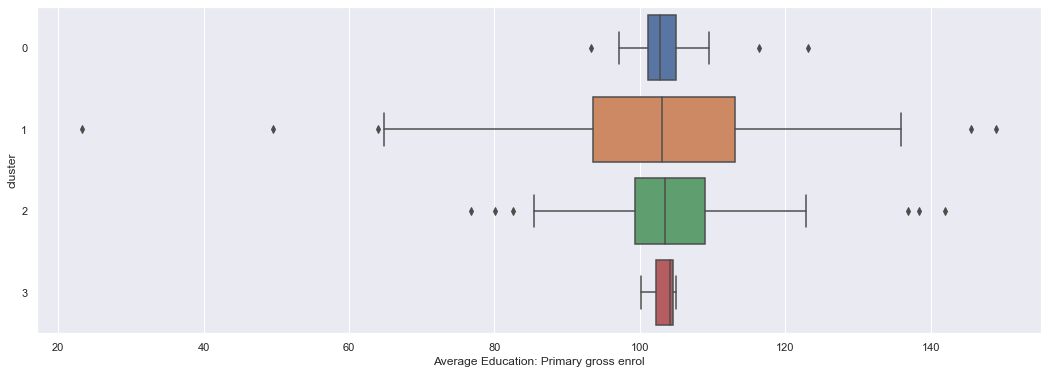

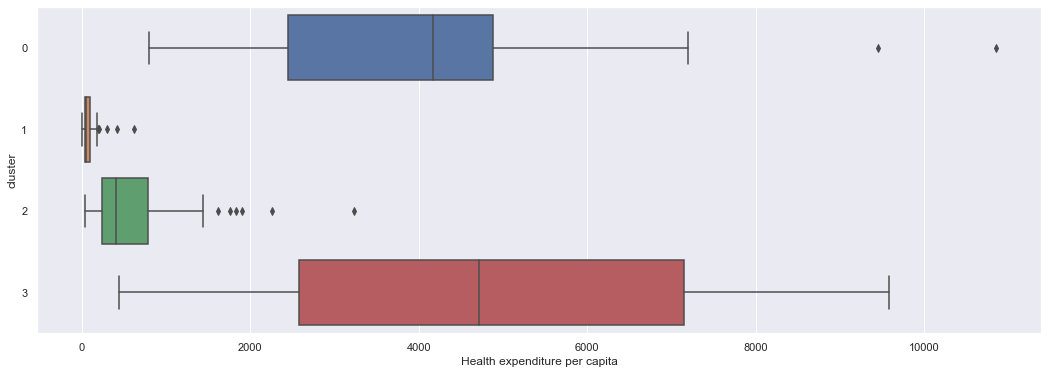

In [79]:
#   plotting boxplots of different clusters for the 15 variables in the final_data dataframe to study 
#   the actual distribution of the development indicators for each cluster (and for verifying that our 
#   clustering is effective)

for col in final_data:
    if col == "country" or col == "Region" or col == "cluster":
        continue
    f = plt.figure(figsize=(18, 6))
    sb.boxplot(x = col, y = "cluster", data = pd.concat([final_data[col], final_data["cluster"]], axis = 1), orient = "h")

From the boxplots above, going by variable #:
1. Clusters 0 and 1 have significantly lower GDP per capita than Clusters 2 and 3, which is indicative of lower economic activity.   
2. Clusters 0 and 1 have a significantly higher proportion of economy made up of agriculture, which is classified as a Primary Economic Sector. Such is indeed a characteristic of a developing/low-income country.   
3. Clusters 0 and 1 have a higher agricultural production index as well. This trend is expected to be less pronounced than the proportion of agriculture in the economy, as more developed countries have higher productivity agricultural methods too. It is just that their economy is much higher in comparison, leading to the more obvious trend for the previous variable.   
4. Clusters 0 and 1 have significantly lower trade exports than Clusters 2 and 3, which is also indicative of lower economic activity.   
5. Clusters 0 and 1 have significantly lower trade imports than Clusters 2 and 3, which is also indicative of lower economic activity.   
6. Cluster 0 has a significantly higher population growth rate, a common characteristic of lower income countries relying on manpower to drive labour intensive jobs in their economy. Cluster 1 on the other hand has a similar population growth rate as Cluster 2, though its median is still higher. This seems to suggest that countries in Cluster 1 is more developed than Cluster 0. Cluster 3 has the lowest population growth rate characteristic of high income countries.   
7. Cluster 0 has a significantly lower urban population, which is indicative of a low income country. Cluster 1 has a higher urban population than Cluster 0, but still lower than Clusters 2 and 3. Fun fact: we found out the outlier for cluster 2 is Liechtenstein, which is a very unique country with a low urban population but one of the highest GDP per capita states in the world.   
8. Clusters 0 and 1 have significantly higher infant mortality rate than Clusters 2 and 3, indicative of a poorer healthcare system and quality of living (access to sanitation) which is characteristic of a low income country.   
9. Cluster 0 has much lower mobile cellular subscriptions per 100 people than the other clusters. This is indicative of a developing country and low income population without access to cellular technology, which is a commodity in richer countries.   
10. Clusters 0 and 1 have significantly lower energy supply than Clusters 2 and 3, indicative of a less developed power grid and power generation infrastructure. This also means they consume less electricity and use less electrical appliances, which is common in lower income countries with lack of access.   
11. Cluster 0 has a much higher average labour force participation, as a lot of manpower is needed for labour intensive lower value added manufacturing and agricultural jobs found in lower income countries.   
12. Clusters 0 and 1 have significantly lower average life expectancy than Clusters 2 and 3, indicative of a poorer healthcare system and quality of living (access to basic necessities) which is characteristic of a low income country.   
13. Clusters 0 and 1 have significantly lower average population using improved drinking water than Clusters 2 and 3, indicative of a lack of resources for water treatment and a good water distribution system which is common in low income countries.   
14. All clusters seem to show a similar distribution for primary education enrolment, with Clusters 0 and 1 showing a higher spread. An analysis reveals countries with high average primary education enrolment have generally low GDP per capita (Malawi, Madagascar, Nepal, Rwanda) and other indications of lower income countries. This seems to invalidate this variable as an indication of level of development of a country.    
15. Clusters 0 and 1 have significantly lower health expenditure per capita compared to Clusters 2 and 3. This can be due to a poor healthcare infrastructure leading to illnesses and diseases going untreated, which is commonly seen in developing countries.   

In [80]:
#Regarding variable 14
final_data[final_data["Average Education: Primary gross enrol"] >= 130]

,GDP per capita (current US$),Economy: Agriculture (% of GVA),Agricultural production index (2004-2006=100),International trade: Exports (million US$),International trade: Imports (million US$),Population growth rate (average annual %),Urban population (% of total population),Infant mortality rate (per 1000 live births,Mobile-cellular subscriptions (per 100 inhabitants),Energy supply per capita (Gigajoules),country,Region,Average labour force participation,Average life expectancy,Average pop. using improved drinking water,Average Education: Primary gross enrol,Health expenditure per capita,cluster
60,7960.7,3.8,97,2851.0,2930.0,3.3,87.2,40.8,168.9,64,Gabon,MiddleAfrica,49.50,64.45,81.95,141.950,270.6638,2
77,4509.0,4.6,123,27341.0,45831.0,3.2,69.5,32.1,93.8,58,Iraq,WesternAsia,42.60,69.20,81.95,138.435,247.995,2
98,401.8,24.9,119,2256.0,2965.0,2.7,35.1,36.8,46.0,7,Madagascar,EasternAfrica,86.40,64.50,58.45,148.900,12.054,1
99,372.9,26.1,149,875.0,1649.0,2.9,16.3,66.5,35.3,6,Malawi,EasternAfrica,81.15,60.65,92.40,145.500,42.5106,1
117,724.5,31.8,139,703.0,5249.0,1.2,18.6,32.8,96.8,19,Nepal,SouthernAsia,83.20,68.90,91.35,135.950,42.021,1
139,697.3,34.6,139,622.0,1778.0,2.5,28.8,44.0,70.5,8,Rwanda,EasternAfrica,84.70,65.10,79.25,132.550,52.2975,1
169,2425.4,5.2,111,94.0,647.0,2.2,32.8,43.9,117.4,7,Timor-Leste,South-easternAsia,41.25,67.80,77.85,136.850,36.381,2


In general, our model has been accurate in identifying Clusters 0 and 1 as countries which are less developed than Clusters 2 and 3. More specifically, Cluster 0 is shown to be even less developed both in infrastructure and economy from the analysis above.

Hence, Cluster 0 seems the right way to go with respect to the allocation of financial aid for development.

In [82]:
# save kmenas model labels to final_data
kmeans_countries = final_data[final_data['cluster'] == 1]
%store kmeans_countries

Stored 'kmeans_countries' (DataFrame)
